## Анализ результатов AB тестирования 

* проанализировать АБ  тест,  проведенный на реальных пользователях Яндекса
* подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control)  и тестовой (exp)  группами
* определить характер этих изменений и практическую значимость вводимого изменения
* понять, какая из пользовательских групп более всего проигрывает / выигрывает   от тестируемого изменения (локализовать изменение)

### Задание 1

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы. 

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите  до третьего знака после точки. 

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests 

In [2]:
data = pd.read_csv('ab_browser_test.csv')
data.shape

(566134, 6)

In [3]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [4]:
control = sum(data.loc[(data['slot'] == 'control')].n_clicks)

In [5]:
exp = sum(data.loc[(data['slot'] == 'exp')].n_clicks)*100 /control

In [6]:
exp-100

1.6135689824415778

### Задание 2

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. 

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [8]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
data.loc[data.slot == 'exp'].n_clicks

0         23
1          3
2         29
4         54
6          6
          ..
566125     0
566126     0
566127     4
566130     4
566133     3
Name: n_clicks, Length: 281580, dtype: int64

### Задание 3

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и  значимым статистически. Последнее утверждение нуждается в дополнительной проверке. 

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах. 

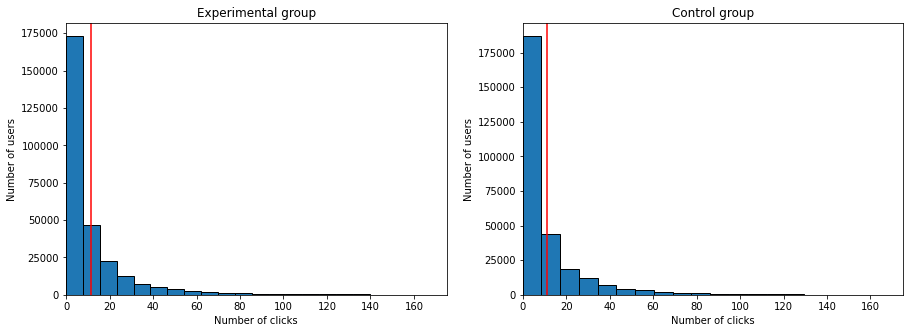

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(data.loc[data.slot == 'exp'].n_clicks, bins=100, edgecolor='k')
plt.axvline(x=(data.loc[data.slot == 'exp'].n_clicks).mean(), ymin=0, ymax=175000, c='r')
plt.xlim(0, 175) 
plt.ylabel('Number of users')
plt.xlabel('Number of clicks')
plt.title('Experimental group')

plt.subplot(122)
plt.hist(data.loc[data.slot == 'control'].n_clicks, bins=100, edgecolor='k')
plt.axvline(x=(data.loc[data.slot == 'control'].n_clicks).mean(), ymin=0, ymax=175000, c='r')
plt.xlim(0, 175) 
plt.ylabel('Number of users')
plt.xlabel('Number of clicks')
plt.title('Control group')
plt.show()

### Задание 4

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control  и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю  соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ?

In [13]:
control = data.loc[(data['slot'] == 'control')][['userID', 'n_clicks']]
control.head()

,userID,n_clicks
3,6,12
5,8,4
7,10,22
9,15,2
13,23,3


In [14]:
exp = data.loc[(data['slot'] == 'exp')][['userID', 'n_clicks']]
exp.head()

,userID,n_clicks
0,1,23
1,3,3
2,5,29
4,7,54
6,9,6


In [15]:
stats.mannwhitneyu(exp, control, alternative='two-sided')

MannwhitneyuResult(statistic=109616091809.0, pvalue=0.0)